In [23]:
import os
import pandas as pd


main_publisher = 'Merged'

script_dir = os.path.dirname(os.path.realpath('__file__'))
path = os.path.join(script_dir, '../Data/' + main_publisher + '/')

df_chapters = pd.read_csv(path + 'chapters.csv', delimiter = '|')
df_chapters_embeddings = pd.read_csv(path + 'embeddings_chapters.csv', delimiter = '|')
df_concepts = pd.read_csv(path + 'concepts_bis.csv', delimiter = '|')
df_concepts_embeddings = pd.read_csv(path + 'embeddings_concepts_bis.csv', delimiter = '|')
df_classes = pd.read_csv(path + 'classes_bis.csv', delimiter = '|')
df_classes_embeddings = pd.read_csv(path + 'embeddings_classes_bis.csv', delimiter = '|')
df_precedences = pd.read_csv(path + 'precedences.csv', delimiter = '|')

df_concepts['Concept'] = df_concepts['Concept'].apply(lambda x : x.split('/')[-1])

print(f'{df_chapters["Cid"].isna().sum().sum():04d} NaN values in chapters.')
print(f'{df_concepts.isna().sum().sum():04d} Nan values in concepts.')
print(f'{df_classes.isna().sum().sum():04d} Nan values in classes.')
print(f'{df_precedences.isna().sum().sum():04d} Nan values in precedence links.')

0000 NaN values in chapters.
0000 Nan values in concepts.
0001 Nan values in classes.
0000 Nan values in precedence links.


In [24]:
def id_mapper(df_col, name):
    unique_id = df_col.unique()
    return pd.DataFrame({
            name : unique_id,
            'mappedID' : pd.RangeIndex(len(unique_id))
        })


unique_oer_id = id_mapper(df_chapters['Cid'], 'OER')
unique_concept_id =  id_mapper(df_concepts['Concept'], 'Concept')
unique_class_id =  id_mapper(df_classes['Class'], 'Class')

In [55]:
import torch 

def edge_construction(df1, df2, col, how, right_on, left_on = None):
    if left_on == None:
        left_on = right_on
    links = pd.merge(df1, df2, right_on = right_on, left_on = left_on, how = how)
    links = torch.from_numpy(links[col].values)
    return links

oer_covers_concept_subject = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'mappedID', 
                                       how = 'left', right_on = 'OER')
oer_covers_concept_pr = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'PR', 
                                          how = 'right', right_on = 'OER')
oer_covers_concept_object = edge_construction(df1 = df_concepts, df2 = unique_concept_id, col = 'mappedID', 
                                       how = 'left', right_on = 'Concept')

oer_before_oer_subject = edge_construction(df1 = df_precedences, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_object = edge_construction(df1 = df_precedences, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')

concept_belongs_class_subject = edge_construction(df1 = df_classes, df2 = unique_concept_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Concept', right_on = 'Concept')
concept_belongs_class_object = edge_construction(df1 = df_classes, df2 = unique_class_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Class', right_on = 'Class')

oer_covers_concept = torch.stack([oer_covers_concept_subject, oer_covers_concept_object], dim = 0)
oer_before_oer = torch.stack([oer_before_oer_subject, oer_before_oer_object], dim = 0)
concept_belongs_class = torch.stack([concept_belongs_class_subject, concept_belongs_class_object], dim = 0)
print(oer_covers_concept)
print(oer_before_oer)
print(concept_belongs_class)

tensor([[   0,    1,    1,  ..., 4406, 4406, 4406],
        [   0,    1,    2,  ...,  875, 7969,  266]])
tensor([[   0,    1,    2,  ..., 4403, 4404, 4405],
        [   1,    2,    3,  ..., 4404, 4405, 4406]])
tensor([[  0.,   1.,   1.,  ..., 266., 266., 266.],
        [  0.,   0.,   1.,  ...,  48.,   4.,   5.]], dtype=torch.float64)


In [93]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['Class'].node_id = torch.tensor(unique_class_id['mappedID'].values)
data['Class'].x = classes_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
data['OER', 'before', 'OER'].edge_index = oer_before_oer
data['Concept', 'belongs', 'Class'].edge_index = concept_belongs_class

data = T.ToUndirected()(data)
data

HeteroData(
  OER={
    node_id=[4407],
    x=[4407, 768]
  },
  Concept={
    node_id=[7970],
    x=[7970, 768]
  },
  Class={
    node_id=[302],
    x=[302, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 24347],
    edge_attr=[24732]
  },
  (OER, before, OER)={ edge_index=[2, 8670] },
  (Concept, belongs, Class)={ edge_index=[2, 72049] },
  (Concept, rev_covers, OER)={ edge_index=[2, 24347] },
  (Class, rev_belongs, Concept)={ edge_index=[2, 72049] }
)

In [122]:
data["OER", "covers", "Concept"]

{'edge_index': tensor([[   0,    1,    1,  ..., 4406, 4406, 4406],
        [   0,    1,    2,  ...,  875, 7969,  266]]), 'edge_attr': tensor([0.0100, 0.0073, 0.0054,  ..., 0.0055, 0.0073, 0.0064],
       dtype=torch.float64)}

In [94]:
transform = T.RandomLinkSplit(
    num_val = 0.2,
    num_test = 0.2,
    #disjoint_train_ratio = 0.5,
    #neg_sampling_ratio = 1.0,
    add_negative_train_samples = True,
    edge_types=('OER', 'before', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before", "OER"].edge_label.detach().numpy())}\t Edges for testing')

10404	 Edges for training
3468	 Edges for validation
3468	 Edges for testing


In [344]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear
import torch.nn.functional as F
from torch import Tensor

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()


        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('OER', 'before', 'OER') : GATConv((-1, -1), hidden_channels, add_self_loops = True, cached = False),
                ('OER', 'covers', 'Concept') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False),
                ('Concept', 'belongs', 'Class') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False)
            }, aggr = 'mean')#experiment with cat for aggr instead of mean
            self.convs.append(conv) 

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x)
            for node_type, x in x_dict.items()
        }
        print("edge_index_dict content : ", edge_index_dict)
        print("x_dict in GNN : ", x_dict.keys())
        print("edge_index_dict items in GNN : ", edge_index_dict.items())
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            #x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin(x_dict_new)


class Classifier(torch.nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.linear = Linear(768 * 2, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, node, edge) -> Tensor:
        print("node : ", node["OER"].shape)
        edge_feat_oer_before = torch.squeeze(node["OER"][edge["before"][0]])
        edge_feat_oer_after = torch.squeeze(node["OER"][edge["before"][1]])
        print("edge nodes : ", edge_feat_oer_before.shape, edge_feat_oer_after.shape)
        edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
        print("edge stacked : ", edge_vec.shape)
        #prod = torch.mul(edge_feat_oer_before, edge_feat_oer_after)
        prod = self.linear(edge_vec)
        return torch.squeeze(prod)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        self.gnn = HeteroGNN(hidden_channels, out_channels, num_layers)
        #self.gnn = self.gnn.float()
        self.classifier = Classifier(hidden_channels * 2)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        print("feature data in model ", data["OER"].x.shape)
        print(data["OER", "before", "OER"].edge_label_index.shape)
        print(data["OER", "covers", "Concept"].edge_index.shape)
        print(data["Concept", "belongs", "Class"].edge_index.shape)
        #print("Type of edge index : ", data["OER", "before", "OER"].edge_label_index.dtype)
        edge_dict = {
            ("OER", "before", "OER"): data["OER", "before", "OER"].edge_label_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index
        }

        #print("number of edges : ", data["OER", "before", "OER"].edge_label.shape)
        print("node dict : ", node_dict.keys())
        print("edge dict : ", edge_dict.keys())
        node_dict = self.gnn(node_dict, edge_dict)
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred


model = Model(hidden_channels = 64, out_channels = 1, num_layers = 2)

In [345]:
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
total_loss = 0
loss_values = []
for epoch in range(1,201):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data)
    ground_truth = train_data["OER", "before", "OER"].edge_label
    assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")

feature data in model  torch.Size([4407, 768])
torch.Size([2, 10404])
torch.Size([2, 24347])
torch.Size([2, 72049])
node dict :  dict_keys(['OER', 'Concept', 'Class'])
edge dict :  dict_keys([('OER', 'before', 'OER'), ('OER', 'covers', 'Concept'), ('Concept', 'belongs', 'Class')])
edge_index_dict content :  {('OER', 'before', 'OER'): tensor([[3406, 1451, 3306,  ...,  539, 2578,  533],
        [3405, 1452, 3307,  ..., 2423, 3072, 1426]]), ('OER', 'covers', 'Concept'): tensor([[   0,    1,    1,  ..., 4406, 4406, 4406],
        [   0,    1,    2,  ...,  875, 7969,  266]]), ('Concept', 'belongs', 'Class'): tensor([[  0.,   1.,   1.,  ..., 266., 266., 266.],
        [  0.,   0.,   1.,  ...,  48.,   4.,   5.]], dtype=torch.float64)}
x_dict in GNN :  dict_keys(['OER', 'Concept', 'Class'])
edge_index_dict in GNN :  dict_items([(('OER', 'before', 'OER'), tensor([[3406, 1451, 3306,  ...,  539, 2578,  533],
        [3405, 1452, 3307,  ..., 2423, 3072, 1426]])), (('OER', 'covers', 'Concept'), ten

ValueError: Expected 'edge_index' to be of integer type (got 'torch.float64')

<function matplotlib.pyplot.show(close=None, block=None)>

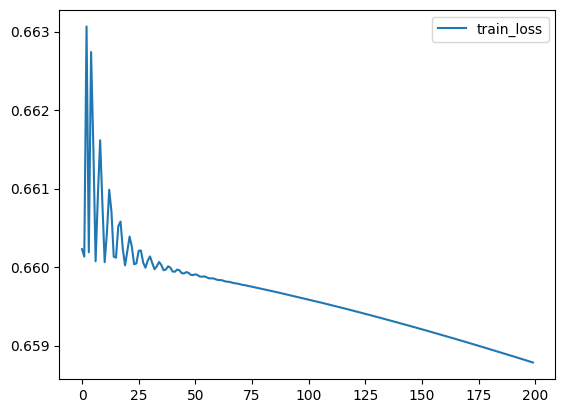

In [283]:
from matplotlib import pyplot as plt

plt.plot(loss_values, label='train_loss')
plt.legend()
plt.show

feature data in model  torch.Size([4407, 768])
node :  torch.Size([4407, 768])
edge nodes :  torch.Size([3468, 768]) torch.Size([3468, 768])
edge stacked :  torch.Size([3468, 1536])
Validation AUC : 0.4247
Validation Precision : 0.4124
Validation Accuracy : 0.4715


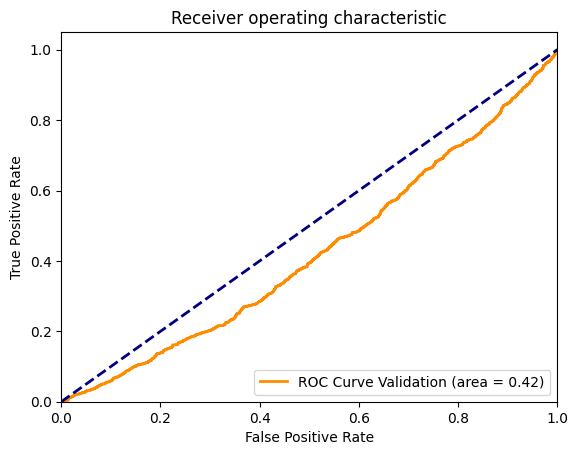

In [275]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, roc_curve, auc

preds = model(val_data).detach().numpy()
preds_labels = (preds > 0.5) * 1
ground_truths = val_data["OER", "before", "OER"].edge_label.detach().numpy()
auc_score = roc_auc_score(ground_truths, preds)
print(f"Validation AUC : {auc_score:.4f}")
precision = precision_score(ground_truths, preds_labels)
print(f"Validation Precision : {precision:.4f}")
accuracy = accuracy_score(ground_truths, preds_labels)
print(f"Validation Accuracy : {accuracy:.4f}")
fpr, tpr, thresholds = roc_curve(ground_truths, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC Curve Validation (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

feature data in model  torch.Size([4407, 768])
node :  torch.Size([4407, 768])
edge nodes :  torch.Size([3468, 768]) torch.Size([3468, 768])
edge stacked :  torch.Size([3468, 1536])
TEST AUC : 0.4314
TEST Precision : 0.4000
TEST Accuracy : 0.4660


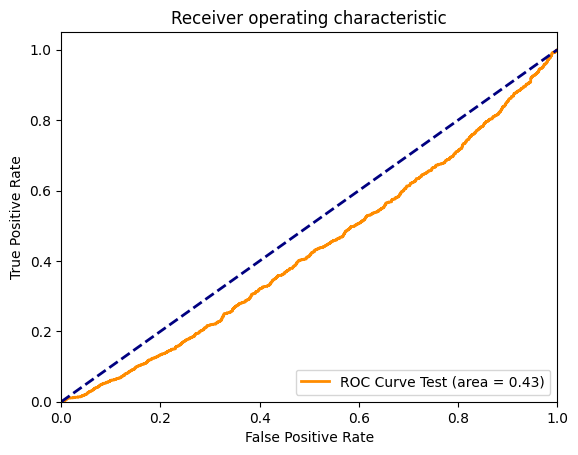

In [276]:
preds = model(test_data).detach().numpy()
preds_labels = (preds > 0.5) * 1
ground_truths = test_data["OER", "before", "OER"].edge_label.detach().numpy()
auc_score = roc_auc_score(ground_truths, preds)
print(f"TEST AUC : {auc_score:.4f}")
precision = precision_score(ground_truths, preds_labels)
print(f"TEST Precision : {precision:.4f}")
accuracy = accuracy_score(ground_truths, preds_labels)
print(f"TEST Accuracy : {accuracy:.4f}")
fpr, tpr, thresholds = roc_curve(ground_truths, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC Curve Test (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()